# Card Image Classification Using EfficientNetB3

## Data Loading

In [38]:
# Exporting dataset via kaggle

!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
cards-image-datasetclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [39]:
# Exporting dataset from zipfile

import zipfile
zip_ref = zipfile.ZipFile('/home/bhxveshhh/DeepLearning/Card Image Classification/cards-image-datasetclassification.zip', 'r')
zip_ref.extractall('/home/bhxveshhh/DeepLearning/Card Image Classification')
zip_ref.close()

## Data Loading

In [ ]:
# Importing Necessory Libraries

import os

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Creating Directories

def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [ ]:

# Data Augmentation

def create_gens(train_df, valid_df, test_df, batch_size):
    
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen


train_dir = '/home/bhxveshhh/DeepLearning/Card Image Classification/train'
valid_dir = '/home/bhxveshhh/DeepLearning/Card Image Classification/valid'
test_dir =  '/home/bhxveshhh/DeepLearning/Card Image Classification/test'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 7624 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.
Found 265 validated image filenames belonging to 53 classes.


## Data Visualization

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

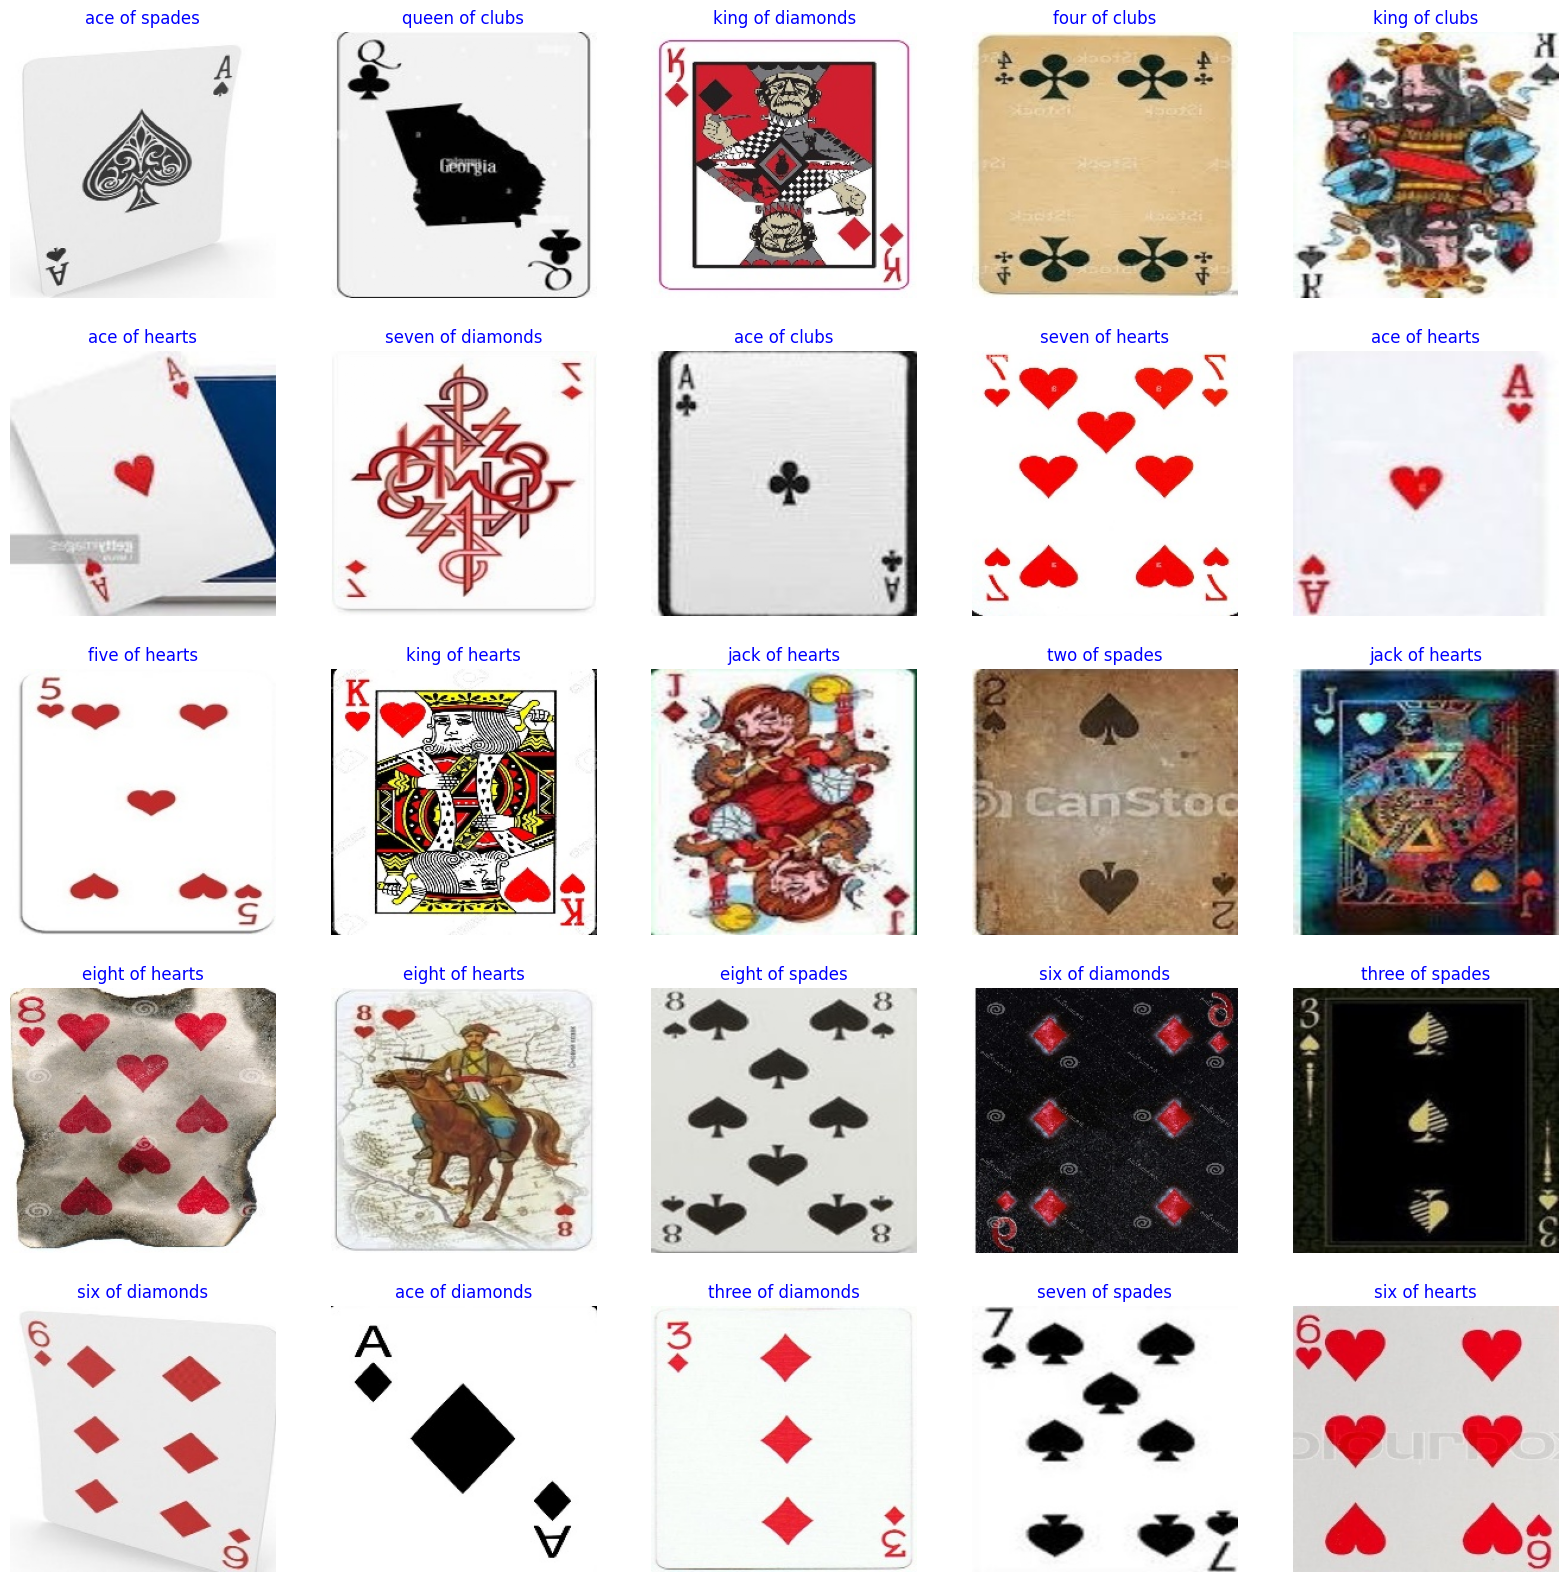

In [11]:
show_images(train_gen)

## Model Training

In [29]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False

In [30]:
model = Sequential([

    base_model,
    BatchNormalization(),    
    Flatten(), 
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')

])

In [31]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_193         │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,203,044 (42.74 MB)

 Trainable params: 416,437 (1.59 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
history = model.fit(
    x=train_gen,
    epochs=75,
    verbose=1,
    validation_data=valid_gen,
)

## Model Evaluation

In [62]:
history_df = pd.DataFrame(history.history)

In [ ]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()